<a href="https://colab.research.google.com/github/saiki050/pytorch_tutorial/blob/main/pytorch%E5%85%A5%E9%96%80/0_4_buildmodel_tutorial_js.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

「PyTorch入門  4. モデル構築」
===============================================================
【原題】BUILD THE NEURAL NETWORK

【原著】
[Suraj Subramanian](https://github.com/suraj813)、[Seth Juarez](https://github.com/sethjuarez/) 、[Cassie Breviu](https://github.com/cassieview/) 、[Dmitry Soshnikov](https://soshnikov.com/)、[Ari Bornstein](https://github.com/aribornstein/)


【元URL】https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　小川 雄太郎

【日付】2021年03月18日

【チュトーリアル概要】

本チュートリアルでは、PyTorchでニューラルネットワークのモデルを構築する方法について解説します

---


ニューラルネットワークモデルの作り方
===================

ニューラルネットワークは、レイヤー（もしくはモジュール）と呼ばれるデータ操作の固まりで構成されています。

[`torch.nn`](https://pytorch.org/docs/stable/nn.html)で用意されているクラス、関数は、独自のニューラルネットワークを構築するために必要な要素を網羅しています。



PyTorchの全てのモジュールは、[`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)を継承しています。


そしてニューラルネットワークは、モジュール自体が他のモジュール（レイヤー）から構成されています。

<br>

この入れ子構造により、複雑なアーキテクチャを容易に構築・管理することができます。

以下で、FashionMNIST datasetの画像データをクラス分類するネットワークモデルを構築します。




In [2]:
%matplotlib inline

In [3]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

---

訓練に使用するデバイス
-----------------------
可能であれば高速に訓練を行うためにも、GPU等を利用したいところです。

GPUが使用可能かどうかは、[`torch.cuda`](https://pytorch.org/docs/stable/notes/cuda.html)の結果から判断できます。

GPUが使用できない場合は、CPUで訓練を行います。



In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


---



クラスの定義
-------------------------
``nn.Module``を継承し、独自のネットワークモデルを定義し、その後ネットワークのレイヤーを ``__init__``で初期化します。

``nn.Module`` を継承した全モジュールは、入力データの順伝搬関数である``forward``関数を持ちます。





In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

``NeuralNetwork``クラスのインスタンスを作成し、変数``device``上に移動させます。

以下でネットワークの構造を出力し確認します。



In [6]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


モデルを利用するには、入力データを与える必要があります。

入力データをモデルに投入すると、``forward``関数で処理されるとともに、いくつかの[`background operations`](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866)が実行されます。

そのため、 ``model.forward()`` と記載して入力データを処理しないように注意してください。



今回のモデルに入力を与えると、各クラスの生の予測値を含む10次元のテンソルが返されます。

``nn.Softmax``モジュールにこの出力結果を与えることで、入力データが各クラスに属する確率の予測値を求めることができます。





In [7]:
X = torch.rand(1, 28, 28, device=device)  # 1つの画像データ（28x28）のテンソル
logits = model(X)  # モデルの出力ロジット（形状は(1, クラス数)）
pred_probab = nn.Softmax(dim=1)(logits)  # 各クラスの確率分布（形状は(1, クラス数)）
y_pred = pred_probab.argmax(1)  # 最も確率が高いクラスのインデックス（形状は(1,)）

print(f"Predicted class: {y_pred}")  # 出力: tensor([4], device='cuda:0')

Predicted class: tensor([5], device='cuda:0')


--------------




モデルレイヤー
-------------------------

FashionMNISTモデルを各レイヤーレベルで確認しましょう。

サイズ28x28の3枚の画像からなるミニバッチのサンプルを用意し、このミニバッチをネットワークに入力し、各処理による変化を確認していきます。



In [8]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


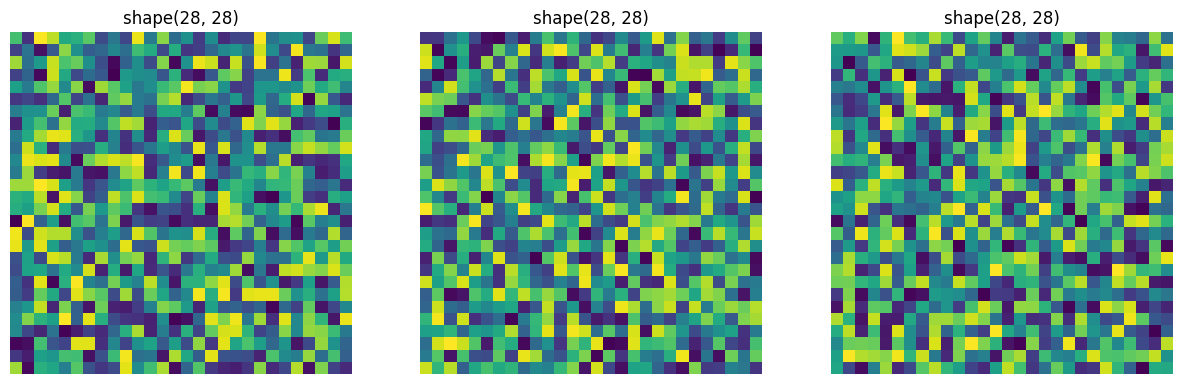

In [9]:
#一応可視化してみる
import matplotlib.pyplot as plt

numpy_image = input_image.cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(len(numpy_image)):
  axes[i].imshow(numpy_image[i])
  axes[i].axis('off')
  axes[i].set_title(f"shape{numpy_image[i].shape}")

plt.show()

**nn.Flatten**

[`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)レイヤーで、2次元（28x28）の画像を、1次元の784ピクセルの値へと変換します。

ミニバッチの0次元目は、サンプル番号を示す次元で、この次元は`nn.Flatten`を通しても変化しません（1次元目以降がFlattenされます）。



In [10]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


**nn.Linear**


[`linear layer`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)は、線形変換を施します。

`linear layer`は重みとバイアスのパラメータを保持しています。





In [11]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


**nn.ReLU**

非線形な活性化関数は、ニューラルネットワークの入力と出力の間にある、複雑な関係性を表現するために重要な要素です。

これらの活性化関数は線形変換のあとに、非線形性を加え、ニューラルネットワークの表現力を向上させる役割をします。

<br>

今回のモデルでは[`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)をlinear layerの間に用意しました。

なお、非線形活性化関数には他にも様々な種類があります。



In [12]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.3457, -0.0404, -0.5101, -0.2621, -0.0321, -0.0751, -0.1396,  0.4486,
         -0.0325, -0.5646,  0.1149,  0.0259, -0.3297, -0.3145,  0.1785,  0.1864,
          0.1237,  0.1676, -0.3223, -0.1353],
        [ 0.3514,  0.1339, -0.3884,  0.3580,  0.4438, -0.1112, -0.4410,  0.3249,
          0.1935, -0.4182,  0.4539,  0.0213, -0.3826, -0.5816, -0.0203,  0.2132,
         -0.4443,  0.3357, -0.3176, -0.2387],
        [ 0.5353, -0.2728, -0.1495, -0.0056,  0.0801, -0.5653, -0.2545, -0.1622,
         -0.0222, -0.3125,  0.3408,  0.3528, -0.4549, -0.8226,  0.1899, -0.1120,
         -0.5188,  0.0316, -0.3865, -0.0745]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.3457, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4486, 0.0000,
         0.0000, 0.1149, 0.0259, 0.0000, 0.0000, 0.1785, 0.1864, 0.1237, 0.1676,
         0.0000, 0.0000],
        [0.3514, 0.1339, 0.0000, 0.3580, 0.4438, 0.0000, 0.0000, 0.3249, 0.1935,
         0.0000, 0.4539, 0.0213, 0.0000, 0.0000, 0.00

**nn.Sequential**

[``nn.Sequential``](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)は、モジュールを順番に格納する箱のような要素です。

入力データは``nn.Sequential``に定義された順番に各モジュールを伝搬します。

<br>

例えば以下の実装例のように、``seq_modules``と名付けた、複数のモジュールを束ねたモジュールを簡単に構築できます。




In [13]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

**nn.Softmax**

ニューラルネットワークの最後のlinear layerは`logits` [- ∞, ∞] を出力します。


この`logits`は[`nn.Softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)モジュールへと渡されます。


その結果、最終的な値は[0, 1]の範囲となり、これは各クラスである確率を示します。


``dim``パラメータは次元を示しており、`dim=1`の次元で和を求めると確率の総和なので1になります。




In [14]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

In [18]:
pred_probab.argmax(1)
# tensor([7,7,6])は１枚目は7, 2枚目は7, 3枚目は6という意味

tensor([7, 7, 6])

---




モデルパラメータ
-------------------------

ニューラルネットワークを構成する多くのモジュールは、おのおのパラメータを保持しています。

例えば、重みやバイアスです。これらの値が訓練時に最適化されます。




``nn.Module`` を継承することで、モデルオブジェクト内で定義されたすべてのフィールドが自動的に追跡でき、``parameters()`` や ``named_parameters()`` メソッドを使って、モデルの各レイヤーのすべてのパラメータにアクセスできるようになります。

以下にfor文を用いて、各パラメータを処理し、そのサイズと値を表示します。



In [ ]:
print("Model structure: ", model, "\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure:  NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
) 


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0346,  0.0327,  0.0167,  ...,  0.0209, -0.0141,  0.0356],
        [ 0.0102,  0.0071,  0.0073,  ..., -0.0241,  0.0041,  0.0159]],
       device='cuda:0', grad_fn=<SliceBackward>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([0.0353, 0.0058], device='cuda:0', grad_fn=<SliceBackward>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0287,  0.0135,  0.0429,  ..., -0.0268,  0.0441, -0.0108],
        [-0.0040,  0.0116,  0.0063,  ...,  0.0297,  0.0293, -0.0179]],
       device='cuda:0

補足  
**"出力＝入力*重み+バイアス"なので、入力(784, 512)の時、重みであるtorch.Sizeは(512,784)**

--------------




さらなる詳細
--------------
以下のページも参考ください。

- [`torch.nn API`](https://pytorch.org/docs/stable/nn.html)



以上。